Импортируем нужные библиотеки

In [1]:
import os
import re
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pymorphy3
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

2024-12-12 18:41:04.705560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733992864.720449  105152 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733992864.724856  105152 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 18:41:04.739905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Делаем проверку на использование GPU

In [2]:
is_cuda = tf.test.is_built_with_cuda()
if is_cuda and len(tf.config.list_physical_devices('GPU'))>=0:
    physical_devices = len(tf.config.list_physical_devices('GPU'))
    print(f"GPU is available.")
else:
    print("GPU not available, CPU used")

GPU is available.


Формируем датафрейм

In [3]:
df = pd.read_csv("./test_dataset.csv")

Получаем первоначальное представление о данных 

In [4]:
df.sample(5)

,news_source_name,news_source_link,category_name,category_link,article_date,article_link,article_title,article_text
1033,lenta,https://lenta.ru/,Ценности,https://lenta.ru/rubrics/style/,2024-08-29T13:18:00+03:00,https://lenta.ru/news/2024/08/29/sputnitsu-dur...,Спутницу Дурова подозревают в работе на израил...,Спутницу Дурова подозревают в работе на израил...
7098,rbk,https://www.rbc.ru/,База знаний,https://www.rbc.ru/base/,2024-10-30T16:08:53+03:00,https://www.rbc.ru/base/30/10/2024/67222f309a7...,Торговый сбор: кто и как должен платить,Содержание: Что такое торговый сбор Преимущест...
3827,lenta,https://lenta.ru/,Мир,https://lenta.ru/rubrics/world/,2024-09-26T22:22:00+03:00,https://lenta.ru/news/2024/09/26/ssha-nazvali-...,США назвали ЕС условия предоставления кредита ...,США назвали ЕС условия предоставления кредита ...
1252,lenta,https://lenta.ru/,Среда обитания,https://lenta.ru/rubrics/realty/,2024-08-29T09:59:00+03:00,https://lenta.ru/news/2024/08/29/top-menedzher...,Топ-менеджер Сбера вошла в наблюдательный сове...,Топ-менеджер Сбера вошла в наблюдательный сове...
2279,lenta,https://lenta.ru/,Россия,https://lenta.ru/rubrics/russia/,2024-09-12T20:29:00+03:00,https://lenta.ru/news/2024/09/12/zakonnost-vey...,В Госдуме раскрыли ситуацию с вопросом законно...,В Госдуме раскрыли ситуацию с вопросом законно...


Удалим дубликаты. Колонка article_link должна быть уникальной для каждой статьи, по ней и проверим.

In [5]:
df["article_link"].duplicated().sum()

np.int64(0)

In [6]:
df = df.drop_duplicates(subset=["article_link"])

Удаляем не нужные колонки и уще раз смотрим на данные

In [7]:
df = df.drop(["news_source_name", "news_source_link", "category_link", "article_date", "article_link"], axis=1)

In [8]:
df.sample(10)

,category_name,article_title,article_text
3288,Экономика,Вице-премьер Сербии ожидает усиление давления ...,"С.-ПЕТЕРБУРГ, 12 сен – РИА Новости. Евросоюз м..."
8246,Спорт,«Это превращается в идиотизм»: завершивший кар...,Бывший чемпион мира по версии Всемирной боксер...
7054,Бизнес,"Глава Total заявил о $2 млрд дивидендов, застр...","Французская TotalEnergies оценила, что к концу..."
2571,Силовые структуры,Вынесен приговор насиловавшему восемь лет падч...,Вынесен приговор насиловавшему восемь лет падч...
3699,База знаний,Налог на профессиональный доход (НПД): что это...,Содержание: Что такое НПД Как работает система...
8168,Армия,"Бойцы ""Востока"" уничтожили три склада боеприпа...","МОСКВА, 2 ноя - РИА Новости. Украинские формир..."
7602,Культура,Звезда «Интернов» опроверг слухи о срочной опе...,Звезда «Интернов» опроверг слухи о срочной опе...
6562,Армия,Вертолеты Ка-52М уничтожили бронетехнику ВСУ в...,"МОСКВА, 18 окт - РИА Новости. Российские верто..."
1694,Армия,"БПЛА незаметно пролетели 1,5 тыс. км: ВСУ впер...",Губернатор Кировской области Александр Соколов...
7909,Путешествия,Аэропорт российского города временно закрыли и...,Аэропорт российского города временно закрыли и...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8403 entries, 0 to 8402
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_name  8403 non-null   object
 1   article_title  8401 non-null   object
 2   article_text   8397 non-null   object
dtypes: object(3)
memory usage: 197.1+ KB


Сразу приведем весь текст к нижнему регистру

In [10]:
df = df.map(lambda x: x.lower() if isinstance(x, str) else x)

Займемся категориями, которые будут служить метками.

In [11]:
df["category_name"].nunique()

28

In [12]:
df["category_name"].unique()

array(['политика', 'экономика', 'общество', 'бизнес',
       'технологии и медиа', 'финансы', 'база знаний', 'россия', 'мир',
       'бывший ссср', 'силовые структуры', 'наука и техника', 'культура',
       'спорт', 'интернет и сми', 'ценности', 'путешествия', 'из жизни',
       'среда обитания', 'забота о себе', 'в мире', 'происшествия',
       'армия', 'наука', 'религия', 'технологии', 'авто', 'стиль'],
      dtype=object)

У нас 28 категорий. Объединим их в общие категории близкие по смыслу. Уникальные категории, категории не вошедшие в обобщенную категорию и строки с пропущенными категориями объединим под одной категорией "Разное"

In [13]:
category_mapping = {
    'политика': 'политика',
    'силовые структуры': 'политика',
    'бывший ссср': 'политика',
    'армия': 'политика',
    'россия': 'политика',

    'экономика': 'экономика и бизнес',
    'бизнес': 'экономика и бизнес',
    'финансы': 'экономика и бизнес',

    'религия': 'общество и культура',
    'общество': 'общество и культура',
    'культура': 'общество и культура',
    'спорт': 'общество и культура',
    'путешествия': 'разное',
    'ценности': 'разное',
    
    'технологии и медиа': 'технологии и наука',
    'наука и техника': 'технологии и наука',
    'интернет и сми': 'технологии и наука',
    'наука': 'технологии и наука',
    'технологии': 'технологии и наука',
    'авто': 'технологии и наука',

    'среда обитания': 'разное',
    'происшествия': 'разное',
    'база знаний': 'разное',
    'мир': 'разное',
    'забота о себе': 'разное',
    'в мире': 'разное',
    'стиль': 'разное',
    'из жизни': 'разное',
}

In [14]:
df["category_name"] = df["category_name"].map(category_mapping)
df["category_name"] = df["category_name"].fillna('разное')

In [15]:
df["category_name"].nunique()

5

In [16]:
df["category_name"].unique()

array(['политика', 'экономика и бизнес', 'общество и культура',
       'технологии и наука', 'разное'], dtype=object)

Посмотрим соотношение категорий

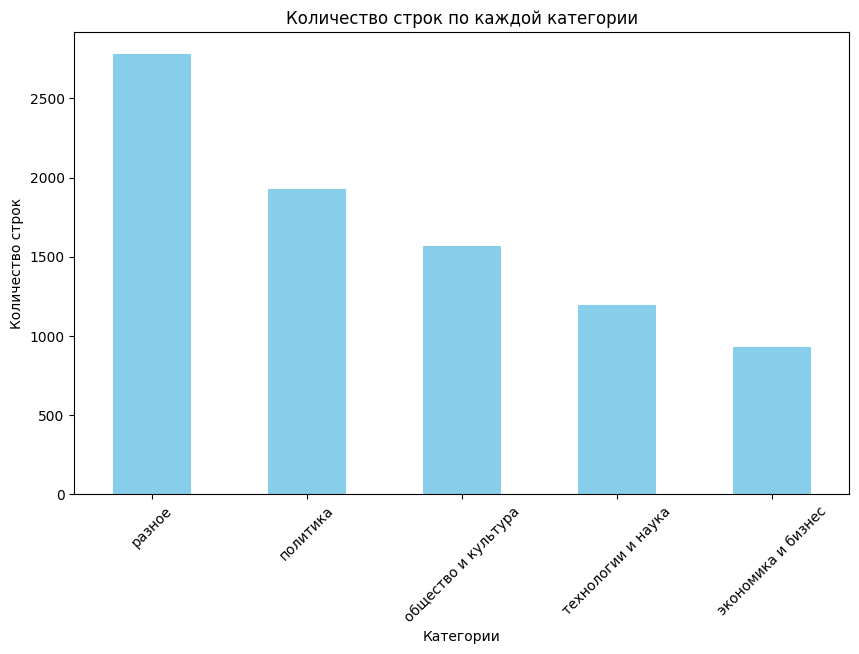

In [17]:
def plt_show_category_counts(df):
    category_counts = df["category_name"].value_counts()

    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar', color='skyblue')
    plt.title("Количество строк по каждой категории")
    plt.xlabel("Категории")
    plt.ylabel("Количество строк")
    plt.xticks(rotation=45)
    plt.show()

plt_show_category_counts(df)

Займемся текстом. Проверим пропущенные значения

In [18]:
df.isna().sum()

category_name    0
article_title    2
article_text     6
dtype: int64

Пустые значения в article_title не страшно, дальше мы будем объединять все в один текст. А вот пустые значения в самой статье необходимо удалить

In [19]:
df = df.dropna(subset=['article_text'])

У нас в некоторых строчках заголовок совпадает с текстом в самой статье. Исправим это заменив дубликат на пустую строчку. После склеим их в один текст и удалим не нужные колонки

In [20]:
df['article_title'] = df.apply(lambda row: '' if row['article_title'] in row['article_text'] else row['article_title'], axis=1)
df['text'] = df['article_title'] + " " + df['article_text']
df.drop(columns=['article_title', 'article_text'], inplace=True)

In [21]:
def random_text(count):
    for _ in range(count):
        random_number = randint(1,df.shape[0])
        print(df["text"].iloc[random_number])
        print("*"*8)

random_text(5)

 в россии с 1 сентября вступил в силу новый штраф для водителей в россии вступил в силу запрет на высадку инвалидов i группы из транспорта в россии с 1 сентября вступил в силу закон, предусматривающий запрет на высадку инвалидов i группы из общественного транспорта за безбилетный проезд. документ размещен на официальном портале правовой информации. нарушившим это требование водителям будет грозить штраф. закон вносит поправки в статью 11.33 кодекса российской федерации об административных правонарушениях и устанавливает наказание за принудительную высадку инвалида первой группы, следующего без сопровождения и не подтвердившего оплату проезда. размер штрафа для водителей составляет 5 тысяч рублей, для должностных лиц — от 20 тысяч до 30 тысяч рублей. о том, что президент россии владимир путин подписал соответствующий закон, сообщалось в июне.
********
 в российском городе пара выбросила котенка с 12-го этажа во время ссоры в уфе пара выбросила котенка с 12-го этажа во время ссоры анна щ

Дальше необходимо избавиться от знаков препинания, стоп слов и другого не нужного.

In [22]:
def preprocess_text(df):
    morph = pymorphy3.MorphAnalyzer()
    stopwords_ru = stopwords.words("russian")
    custom_stopwords = []

    def deEmojify(text):
        regrex_pattern = re.compile(pattern = "["
                                    u"\U00000000-\U00000009"
                                    u"\U0000000B-\U0000001F"
                                    u"\U00000080-\U00000400"
                                    u"\U00000402-\U0000040F"
                                    u"\U00000450-\U00000450"
                                    u"\U00000452-\U0010FFFF"
                                    "]+", flags = re.UNICODE)
        return regrex_pattern.sub(r'',text)

    def process_text(text):
        tokens = []
        cleaned_text = re.sub(r'\d+', '', text)
        cleaned_text = re.sub(r'[!"#$%&\'()*+,\-./:;<=>?\[@\\\]^_`{|}~]', '', cleaned_text)
        cleaned_text = deEmojify(cleaned_text)
        for token in cleaned_text.split():
            if token and token not in stopwords_ru:
                token = token.strip()
                token = morph.parse(token)[0].normal_form  
                if token not in custom_stopwords:
                    tokens.append(token)          
        return " ".join(tokens)
    
    df["text"] = df["text"].apply(process_text)

    return df

In [23]:
df = preprocess_text(df)

Посмотрим на облако слов и какие слова встречаются сколько раз

In [24]:
def create_wordcloud(df):
    all_text = " ".join(df["text"])
    words = all_text.split()
    word_counts = Counter(words)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    return word_counts

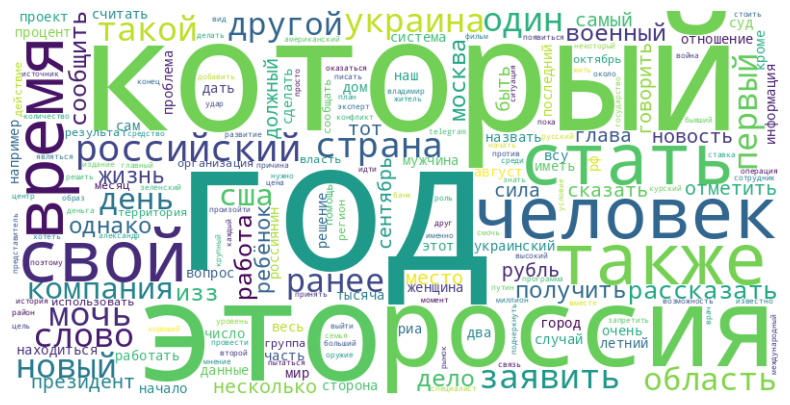

In [25]:
word_counts = create_wordcloud(df)

In [26]:
word_counts

Counter({'год': 23184,
         'который': 18711,
         'это': 14435,
         'россия': 10840,
         'человек': 8419,
         'также': 8099,
         'стать': 7992,
         'свой': 7942,
         'время': 7216,
         'российский': 6583,
         'страна': 5940,
         'мочь': 5695,
         'украина': 5475,
         'слово': 5451,
         'один': 5381,
         'такой': 5316,
         'заявить': 5225,
         'новый': 5091,
         'ранее': 4820,
         'первый': 4692,
         'другой': 4431,
         'область': 4417,
         'день': 4226,
         'сша': 4224,
         'компания': 4165,
         'рассказать': 4095,
         'дело': 3920,
         'работа': 3825,
         'военный': 3730,
         'изз': 3683,
         'сообщить': 3631,
         'москва': 3484,
         'получить': 3454,
         'однако': 3435,
         'жизнь': 3284,
         'ребёнок': 3128,
         'президент': 3106,
         'несколько': 3060,
         'рубль': 3001,
         'должный': 2914,

Некоторые слова встречаются очень много раз, но не имеют информационного веса. Создадим список таких слов и удалим их

In [27]:
# Я остановился на словах, которые встречаются более 2000 раз
custom_stopwords = [
    "год", "риа", "это",
    "также", "изз", "тот",
    "очень", "сам", "этот",
    "наш",
]

In [28]:
def cleaning_custom_stopwords(df):

    def process_text(text):
        tokens = []
        for token in text.split():
            if token and token not in custom_stopwords:
                tokens.append(token)
        return " ".join(tokens)  

    df["text"] = df["text"].apply(process_text)

    return df

In [29]:
df = cleaning_custom_stopwords(df)

In [30]:
random_text(5)

врач поставить точка вопрос полезность хлеб гастроэнтеролог крылов хлеб полезный работа мозг здоровье целое наталья обрядин редактор отдел забота хлеб любой другой продукт свой плюс минус полностью исключать рацион стоить считать гастроэнтеролог ведущий специалист сеть клиника семейный светлана крылов поставить точка вопрос полезность продукт разговор лентойра крылов заявить воздержаться употребление хлеб человек непереносимость глютен целиакия остальной человек продукт полезный являться ценный источник углевод который необходимый восполнение энергия организм правильный работа мозг здоровье целое считать врач слово хлеб пищевой волокно витамин минерал хлеб богатый витамин группа железо магний другой важный питательный вещество особенно изготовить цельный зерно кроме цельнозернов сорт хлеб клетчатка способствовать правильный пищеварение помогать поддерживать нормальный уровень сахар кровь светлана крылов гастроэнтеролог терапевт гастроэнтеролог рекомендовать злоупотреблять белый хлеб не

Вернемся к количеству строк в каждой категории и сбалансируем их

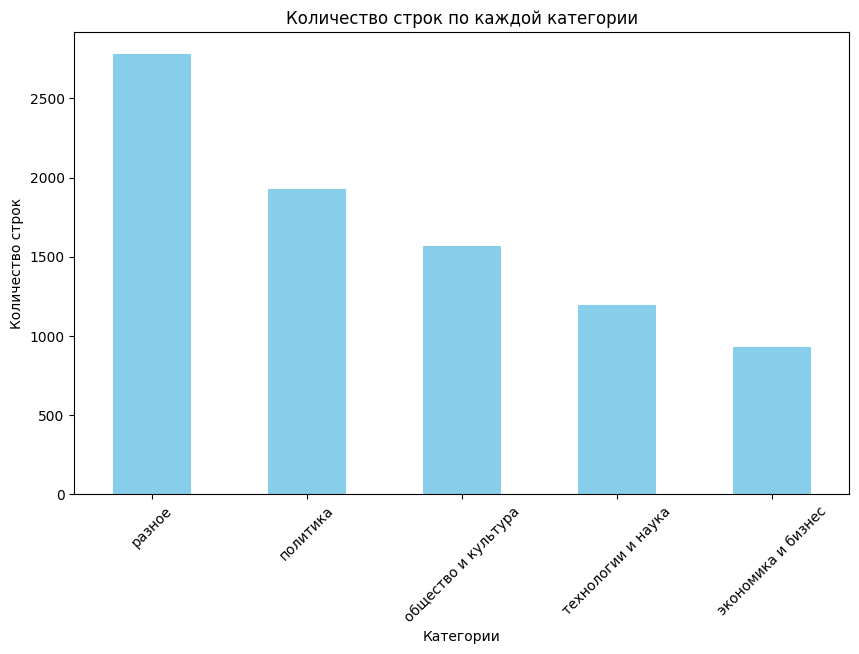

In [31]:
plt_show_category_counts(df)

In [32]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
avg_word_count = df['word_count'].mean()

min_samples = df['category_name'].value_counts().min()

In [33]:
balanced_df = pd.DataFrame(columns=df.columns)

In [34]:
def balancing_samples(category_data):
        category_avg_word_count = category_data['word_count'].mean()

        # Если количество строк больше min_samples
        while len(category_data) > min_samples:
            if category_avg_word_count > avg_word_count:
                # Убираем самые длинные строки, пока среднее количество слов не станет <= avg_word_count
                category_data = category_data.drop(category_data['word_count'].idxmax())
            else:
                # Удаляем самые короткие строки, пока среднее количество слов не станет >= avg_word_count
                category_data = category_data.drop(category_data['word_count'].idxmin())

            # Пересчитываем среднее количество слов в категории после удаления строки
            category_avg_word_count = category_data['word_count'].mean()

        # Если количество строк меньше или равно min_samples, возвращаем данные как есть
        return category_data.reset_index(drop=True)

for category in df["category_name"].unique():
    category_data = df[df["category_name"] == category].copy()
    print(f"Категория обработки: '{category}'")

    balanced_category_data = balancing_samples(category_data)

    balanced_df = pd.concat([balanced_df, balanced_category_data], ignore_index=True)

    print(f"Категория '{category}' сбалансирована. Количество строк после балансировки: {len(balanced_category_data)}")
    print()

Категория обработки: 'политика'
Категория 'политика' сбалансирована. Количество строк после балансировки: 929

Категория обработки: 'экономика и бизнес'
Категория 'экономика и бизнес' сбалансирована. Количество строк после балансировки: 929

Категория обработки: 'общество и культура'
Категория 'общество и культура' сбалансирована. Количество строк после балансировки: 929

Категория обработки: 'технологии и наука'
Категория 'технологии и наука' сбалансирована. Количество строк после балансировки: 929

Категория обработки: 'разное'
Категория 'разное' сбалансирована. Количество строк после балансировки: 929



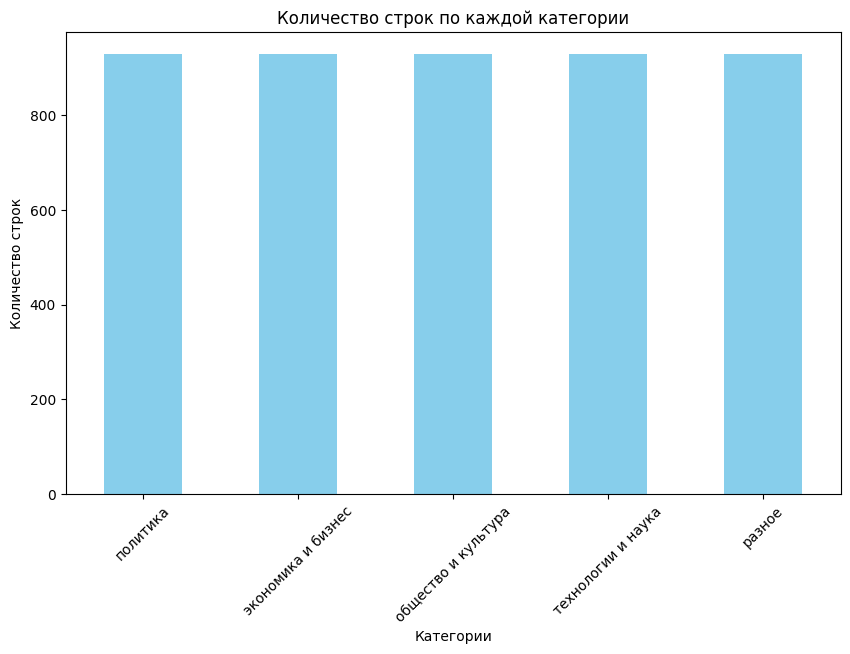

In [35]:
plt_show_category_counts(balanced_df)

Проверим минимальную, максимальную и среднюю длину текста

In [36]:
balanced_df['text_length'] = balanced_df['text'].str.len()

In [37]:
def plt_show_length(df):

    text_length_stats = df.groupby('category_name')['text_length'].agg(['min', 'max', 'mean']).reset_index()

    print("*"*30)
    print(text_length_stats)
    print("*"*30)

    plt.figure(figsize=(10, 6))

    # Точки для максимальных значений
    plt.scatter(text_length_stats['category_name'], text_length_stats['max'], label='Максимальная длина', color='r', s=100)

    plt.scatter(text_length_stats['category_name'], text_length_stats['mean'], label='Средняя длина', color='g', s=100)

    # Точки для минимальных значений
    plt.scatter(text_length_stats['category_name'], text_length_stats['min'], label='Минимальная длина', color='b', s=100)

    plt.xlabel('Категории')
    plt.ylabel('Длина текста (символы)')
    plt.title('Минимальная и максимальная длина текста по категориям')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.show()

******************************
         category_name   min    max         mean
0  общество и культура   662   8576  2292.964478
1             политика   823   8712  2333.691066
2               разное  1037   8059  2288.138859
3   технологии и наука   806   9165  2351.051668
4   экономика и бизнес   175  21557  2727.257266
******************************


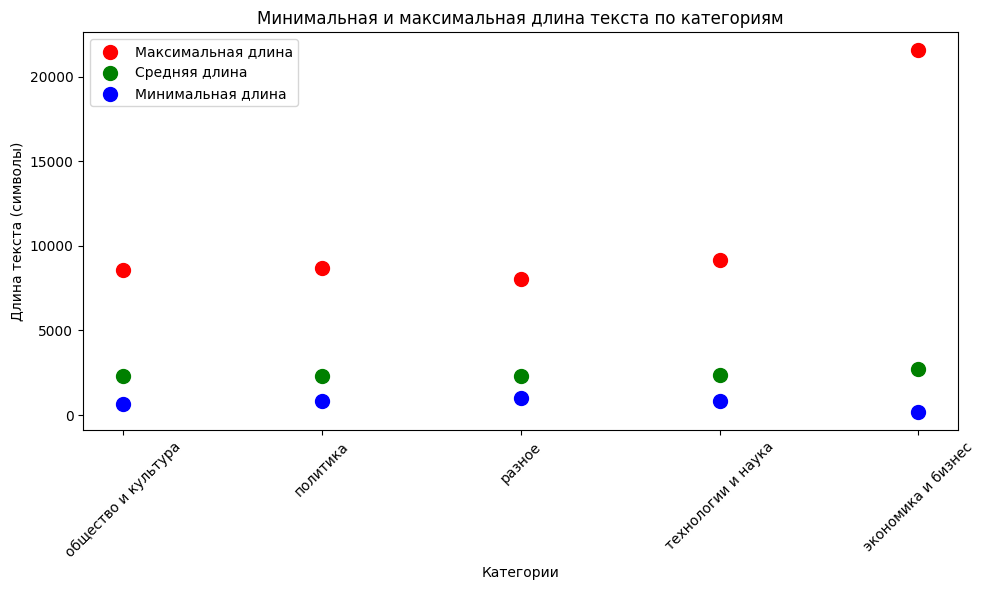

In [38]:
plt_show_length(balanced_df)

Удалим слишком большой текст

In [39]:
final_df = balanced_df.copy()

for index, row in balanced_df.iterrows():
    if row['text_length'] < 200 or row['text_length'] > 10000:
        final_df.drop(index, inplace=True)

******************************
         category_name   min   max         mean
0  общество и культура   662  8576  2292.964478
1             политика   823  8712  2333.691066
2               разное  1037  8059  2288.138859
3   технологии и наука   806  9165  2351.051668
4   экономика и бизнес   206  9907  2286.996641
******************************


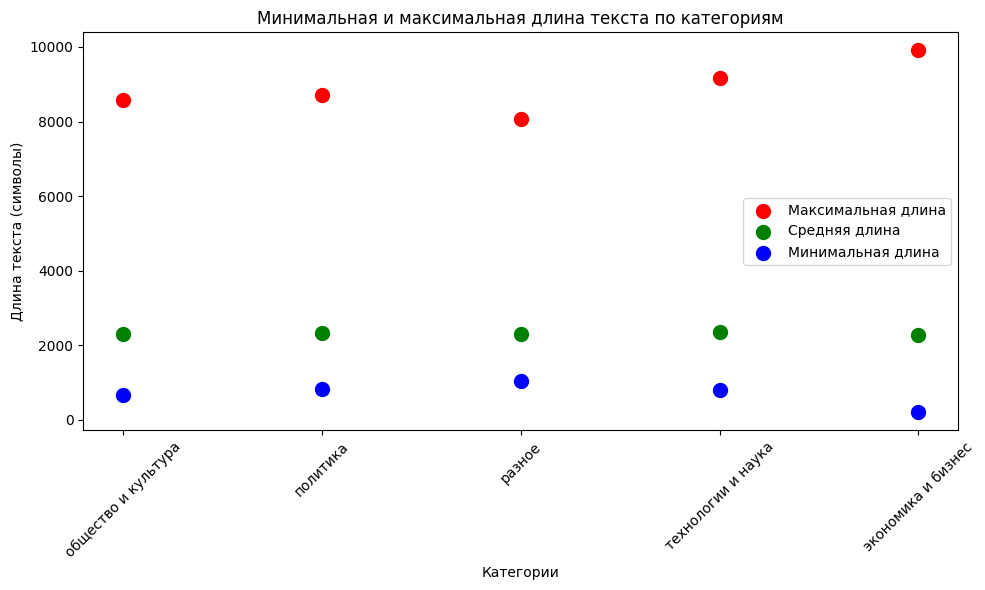

In [40]:
plt_show_length(final_df)

Мы провели предобработку текста и сбалансировали данные. Перед тем как перейти непосредственно к выборкам и модели необходимо закодировать метки и создать словарь. А так же удалить всё не нужное.

In [41]:
label_encoder = LabelEncoder()
final_df["category_encoded"] = label_encoder.fit_transform(final_df["category_name"])
category_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

In [42]:
del balanced_df, df

final_df = final_df.drop(["word_count", "text_length", "category_name"], axis=1)

Посмотрим на наши данные

In [43]:
final_df.sample(5)

,text,category_encoded
4129,суд арестовать глава мемориал минобороны дело ...,2
3069,ия научиться определять давление голос ieee ac...,3
4373,эверест наслать останки альпинист пропасть сто...,2
3758,камала харрис кандидат пост президент сша мода...,2
101,фсб задержать герой россия генерал булгаков об...,1


In [44]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4609 entries, 0 to 4644
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   text              4609 non-null   object
 1   category_encoded  4609 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 108.0+ KB


Скачаем и инициализируем библиотеку предобученных эмбедингов Natasha/Navec

In [45]:
if not os.path.exists("navec_hudlit_v1_12B_500K_300d_100q.tar"):
    !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
else:
    print("Уже скачан")

Уже скачан


In [46]:
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

Преобразуем текст в векторное представление с использованием предобученной модели

In [47]:
def text_to_vector(text, model):
    words = text.split()
    word_vectors = []

    for word in words:
        try:
            word_vectors.append(model[word])
        except KeyError:
            continue

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X = np.array([text_to_vector(text, navec) for text in final_df['text']])
y = final_df['category_encoded'].astype(int)

Разделим наши данные на выборки

In [48]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_tmp,
                                                  y_tmp,
                                                  test_size=0.5,
                                                  random_state=42)

In [49]:
perform_list = [ ]

Функция `run_model` предназначена для выполнения процесса обучения и оценки модели машинного обучения. Она принимает на вход название модели, обучает указанную модель и выводит её метрики производительности.

In [50]:
def run_model(model_name):
    mdl = ''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(
            n_estimators=100, criterion='entropy', random_state=0)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(X_train, y_train)
    y_pred = oneVsRest.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    precision, recall, f1score, support = score(
        y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'F1-score : {f1score}')

    perform_list.append(dict([

        ('Model', model_name),

        ('Test Accuracy', round(accuracy, 2)),

        ('Precision', round(precision, 2)),

        ('Recall', round(recall, 2)),

        ('F1', round(f1score, 2))

    ]))

In [51]:
run_model('Logistic Regression')

Test Accuracy Score of Basic Logistic Regression: % 77.87
Precision : 0.7787418655097614
Recall : 0.7787418655097614
F1-score : 0.7787418655097614


In [52]:
run_model('Random Forest')

Test Accuracy Score of Basic Random Forest: % 81.56
Precision : 0.8156182212581344
Recall : 0.8156182212581344
F1-score : 0.8156182212581344


In [53]:
run_model('Support Vector Classifer')

Test Accuracy Score of Basic Support Vector Classifer: % 81.13
Precision : 0.8112798264642083
Recall : 0.8112798264642083
F1-score : 0.8112798264642083


In [54]:
run_model('Decision Tree Classifier')

Test Accuracy Score of Basic Decision Tree Classifier: % 50.11
Precision : 0.5010845986984815
Recall : 0.5010845986984815
F1-score : 0.5010845986984815


In [55]:
run_model('K Nearest Neighbour')

Test Accuracy Score of Basic K Nearest Neighbour: % 76.14
Precision : 0.7613882863340564
Recall : 0.7613882863340564
F1-score : 0.7613882863340564


In [56]:
run_model('Gaussian Naive Bayes')

Test Accuracy Score of Basic Gaussian Naive Bayes: % 70.28
Precision : 0.702819956616052
Recall : 0.702819956616052
F1-score : 0.702819956616052


Сравниваем все модели

In [57]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,77.87,0.78,0.78,0.78
1,Random Forest,81.56,0.82,0.82,0.82
2,Support Vector Classifer,81.13,0.81,0.81,0.81
3,Decision Tree Classifier,50.11,0.50,0.50,0.50
4,K Nearest Neighbour,76.14,0.76,0.76,0.76
5,Gaussian Naive Bayes,70.28,0.70,0.70,0.70


In [58]:
model = model_performance["Model"]
max_value = model_performance["Test Accuracy"].max()
best_model_row = model_performance[model_performance["Test Accuracy"] == max_value]
best_model_name = best_model_row["Model"].values[0]

print("Лучшая точность среди моделей: ", max_value)
print("Модель с лучшей точностью:", best_model_name)

Лучшая точность среди моделей:  81.56
Модель с лучшей точностью: Random Forest


Используем лучшую модель для дальнейшего анализа

In [59]:
classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0).fit(X_train, y_train)

In [60]:
y_pred = classifier.predict(X_test)

In [61]:
report = classification_report(y_test, y_pred, output_dict=True)

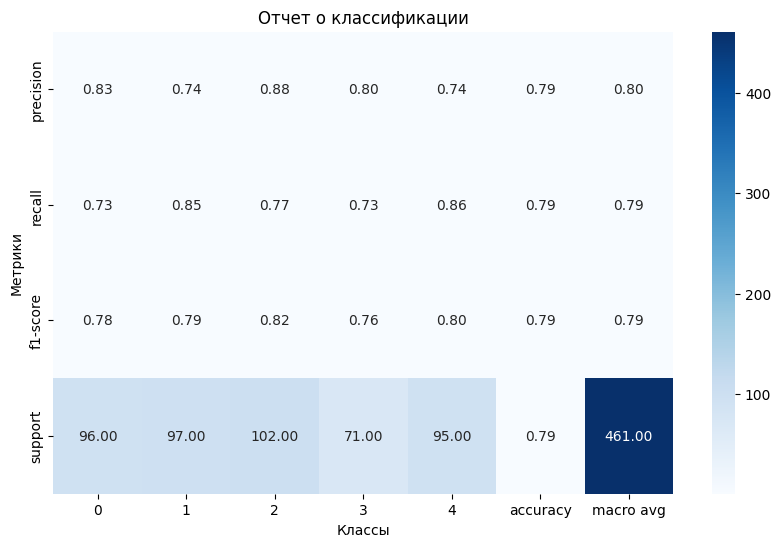

In [62]:
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Отчет о классификации')
plt.xlabel('Классы')
plt.ylabel('Метрики')
plt.show()

In [63]:
conf_matrix = confusion_matrix(y_test, y_pred)

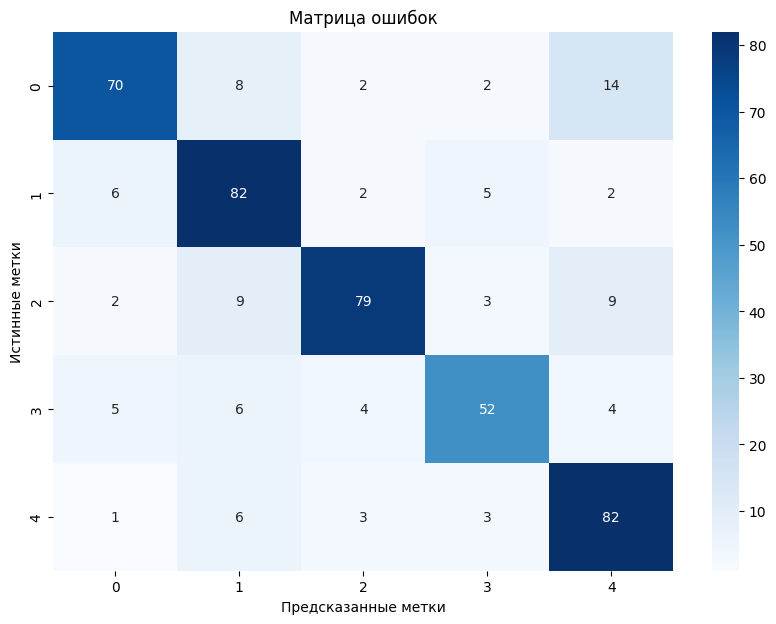

In [64]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

Создадим несколько кастомных новостей. Эти новости реальны и были взяты с новостных порталов

In [65]:
test_text_economy = """
        Средний размер потребкредита в России упал до минимума с 2017 года.
        МОСКВА, 12 дек - РИА Новости. Россияне в ноябре в среднем брали потребкредиты на 132,4 тысячи рублей - это минимум за последние семь лет, рассказали РИА Новости в "Скоринг бюро".
        Банки начали сокращать средний размер кредита в июле, когда ЦБ впервые в этом году поднял ключевую ставку. С тех пор показатель все время уменьшался.
        В ноябре он упал до 132,4 тысячи рублей. "Такой показатель в последний раз встречался во втором квартале 2017 года - после этого периода россияне всегда занимали в банках больше", - прокомментировали в бюро кредитных историй.
        При этом в прошлом месяце показатель уменьшился сразу на 13,4% по сравнению с октябрем - это стало максимальным месячным падением с марта 2022 года.
        Среди причин сокращения в бюро назвали рекордную ключевую ставку ЦБ, которая в конце октября была повышена до 21%, а также ужесточение регулирования. Осенью Банк России ужесточил ряд ограничений на выдачу необеспеченных потребкредитов.
"""

test_text_science = """
        В России разработали биопринтер для лечения незаживающих ран.
        МОСКВА, 11 дек - РИА Новости. Портативный биопринтер для биопечати тканевого эквивалента кожи, который будет эффективен для лечения незаживающих ран, разрабатывают ученые Сеченовского университета, сообщила пресс-служба вуза.
        "В Клинике кожных и венерических болезней имени В.А. Рахманова, Институте регенеративной медицины и Дизайн-центра гибкой биоэлектроники Сеченовского университета разрабатывают портативный биопринтер "Биоган" для биопечати тканевого эквивалента кожи, который будет эффективен для лечения незаживающих или плохо заживающих язв, в том числе диабетической природы", - говорится в сообщении.
        Для тестирования системы ученые планируют провести эксперимент на мини-пигах, уточнили в пресс-службе.
        Созданное устройство будет представлять собой аппаратный комплекс, который используется для транспортировки, нанесения и облучения биочернил, пояснили разработчики.
        Сами биочернила состоят из двух основных компонентов, которые хранятся в отдельных картриджах. Первый картридж содержит гидрогель, созданный на основе желатина, в него добавлены клетки самого пациента. Во втором картридже находятся сшивающие агенты, которые ускоряют процесс затвердевания гидрогеля, рассказали в пресс-службе.
        После нанесения гидрогель подвергается облучению ультрафиолетом, чтобы он затвердел и не стек с раны, а затем используется инфракрасное излучение для стимуляции роста клеток, отметили в университете.
"""

test_text_politics = """
        Госдума досрочно прекратила депутатские полномочия Хинштейна.
        МОСКВА, 11 дек – РИА Новости. Госдума на пленарном заседании досрочно прекратила депутатские полномочия Александра Хинштейна, который был назначен врио губернатора Курской области.
        Совет Госдумы в понедельник принял решение предложить депутата Сергея Боярского замещающим должность главы думского комитета по информационной политике, информационным технологиям и связи, сообщил ранее РИА Новости источник в Госдуме.
        В минувший четверг 5 декабря президент РФ Владимир Путин подписал указ "Об исполняющем обязанности губернатора Курской области". В связи с заявлением губернатора Курской области Алексея Смирнова о досрочном прекращении полномочий временно исполняющим обязанности главы региона был назначен Хинштейн. 7 декабря полномочный представитель президента РФ в ЦФО Игорь Щеголев представил правительству Курской области нового врио губернатора.
"""

test_text_society_and_culture_subtitle_sport = """
        "Монако" с Головиным уступил "Арсеналу" в Лиге чемпионов.
        МОСКВА, 12 дек - РИА Новости. Английский "Арсенал" разгромил "Монако" в матче шестого тура основного этапа футбольной Лиги чемпионов.
        Встреча, прошедшая в Лондоне, завершилась со счетом 3:0. Дубль оформил Букайо Сака (34-я, 78-я минуты), еще один мяч забил Кай Хаверц (88).
        Российский полузащитник "Монако" Александр Головин провел на поле весь матч.
        "Арсенал" (13 очков) занимает третье место в турнирной таблице Лиги чемпионов. "Монако" (10) располагается на 16-й строчке.
        В следующем туре "Арсенал" 22 января примет хорватское "Динамо" (Загреб), "Монако" 21 января дома сыграет с английской "Астон Виллой".
"""

test_text_others_subtitle_habitat = """
        «Это такой кайф, когда ты сам можешь совершить даже какой-то банальный платеж за квартиру».
        Сбер представил пятый выпуск подкаста «По пути к инклюзии» — «Доступность — это про независимость». Он приурочен к Международному дню незрячих, который прошел 13 ноября. В новом эпизоде речь шла и о том, как современные технологии позволяют людям с инвалидностью самостоятельно управлять своими финансами. Также эксперты рассказали как защитить себя от мошенников и объяснили, что такое финансовая эксплуатация.

        Эксперт по кибербезопасности Сбербанка Анастасия Зубова рассказала, что ежедневно россиянам поступает до 20 миллионов звонков от мошенников. Она напомнила, что сотрудники Сбербанка звонят только с номера 900 и не запрашивают персональную информацию. В мобильном приложении можно проверить безопасность сайтов, подключить сервис блокировки и проверки входящих звонков, тем самым обезопасив себя от мошенников. Существует также термин финансовая эксплуатация. «Это когда один близкий делает плохо другому близкому посредством денег», — объяснила эксперт команды Особенного банка (специальное подразделение Сбера, миссия которого — делать сервисы доступными для всех) Екатерина Рассудительнова. В зоне риска оказываются люди с инвалидностью, пенсионеры, женщины и те, у кого нет постоянного дохода. «Помочь выйти из этой ситуации могут специальные фонды и центры, которые есть в каждом регионе, а также юристы, имеющие опыт в таких вопросах», — добавила эксперт.

        Особое внимание в ролике уделено инструментам безопасности незрячих людей. Незрячий тестировщик и разработчик многих решений в команде Особенного банка Павел Попко, рассказал о том, с какими сложностями он сталкивался в жизни и как те решения, которые внедряет Сбер, помогают людям с инвалидностью. Еще он продемонстрировал, как телефон общается с ним «голосом». «Незрячего человека, по понятным причинам, обмануть гораздо проще. Поэтому я не устаю говорить о том, что личная ответственность каждого играет большую роль. И нужно самому предпринимать определенные шаги, чтобы становиться финансово грамотным», — заключил Попко.

        За последние 20 лет, по мнению Павла, прогресс настолько далеко шагнул, что даже незрячие люди получили возможность безопасно и самостоятельно управлять своими финансами. И в Сбере этому уделено большое внимание. «Когда говорят про доступность, то подразумевают какие-то нормативы, требования, ГОСТы. Удобно или неудобно — это второй вопрос, потому что удобство — это уже, как правило, личное мнение. Когда я тестирую какие-то продукты, я оцениваю их и с точки зрения доступности, и с точки зрения удобства, как будущий пользователь. Я точно не хочу сделать то, что нашему клиенту будет доступно, но ужас как неудобно. Я люблю шутить по этому поводу: работодатель может не сомневаться в моей работе, потому что я как никто заинтересован в том, чтобы эти решения работали. Если я сделаю свою работу хорошо, то я буду сам пользоваться всеми возможностями, мои друзья, другие люди. Это то, что заставляет меня двигаться каждый день вперед», — рассказал Павел.

        Развитие технологий не стоит на месте, и перед разработчиками появляются новые вызовы. Например, как ввести пин-код на сенсорном терминале, где в принципе нет никаких кнопок. Решение нашли в том же самом Особенном банке — там разработали решение, как вводить пин-код шрифтом Брайля на сенсорном терминале. В ближайшее время эта функция будет доступно на всех сенсорных терминалах Сбера.
        
"""

In [66]:
test_dic = [
    {
        "text": test_text_economy,
        "category": "Экономика"
    },
    {
        "text": test_text_science,
        "category": "Наука"
    },
    {
        "text": test_text_politics,
        "category": "Политика"
    },
    {
        "text": test_text_society_and_culture_subtitle_sport,
        "category": "Общество и культура (на сайте 'Спорт')"
    },
    {
        "text": test_text_others_subtitle_habitat,
        "category": "Разное (на сайте 'среда обитания')"
    }
]

Переведем их в нужный формат и проверим

In [67]:
morph = pymorphy3.MorphAnalyzer()
stopwords_ru = stopwords.words("russian")
custom_stopwords = []

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
                                u"\U00000000-\U00000009"
                                u"\U0000000B-\U0000001F"
                                u"\U00000080-\U00000400"
                                u"\U00000402-\U0000040F"
                                u"\U00000450-\U00000450"
                                u"\U00000452-\U0010FFFF"
                                "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def process_text(text):
    tokens = []
    cleaned_text = re.sub(r'\d+', '', text)
    cleaned_text = re.sub(r'[!"#$%&\'()*+,\-./:;<=>?\[@\\\]^_`{|}~]', '', cleaned_text)
    cleaned_text = deEmojify(cleaned_text)
    for token in cleaned_text.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.parse(token)[0].normal_form  
            if token not in custom_stopwords:
                tokens.append(token)          
    return " ".join(tokens)

In [68]:
for num, test in enumerate(test_dic):
    test_text = test["text"].lower()
    test_text = process_text(test_text)
    test_text = text_to_vector(test_text, navec)
    yy = classifier.predict(np.array([test_text]))

    print(f"Проверка № {num+1}")

    print(f"{'Реальная категория:':<30} {test['category']:>30}")
    print(f"{'Модель предсказала категорию:':<30} {category_mapping[yy[0]]:>30}")

    print()
    

Проверка № 1
Реальная категория:                                 Экономика
Модель предсказала категорию:              экономика и бизнес

Проверка № 2
Реальная категория:                                     Наука
Модель предсказала категорию:              технологии и наука

Проверка № 3
Реальная категория:                                  Политика
Модель предсказала категорию:                        политика

Проверка № 4
Реальная категория:            Общество и культура (на сайте 'Спорт')
Модель предсказала категорию:             общество и культура

Проверка № 5
Реальная категория:            Разное (на сайте 'среда обитания')
Модель предсказала категорию:              технологии и наука



Здесь нужно отметить, что категория "Разное", достаточно обобщенная категория и у нее нет четко выроженых признаков.
По  этой причине модель может классифицировать новость как другую категорию. В нашем примере `test_text_others_subtitle_habitat` была взята из категории среда обитания с сайта. Но если прочитать саму статью, то становится понятно по какой причине модель отнесла ее к категории "технологии и наука".